In [32]:
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [40]:
cases = pd.read_csv('confirmed.csv')
deaths = pd.read_csv('deaths.csv')
recovered = pd.read_csv('recovers.csv')

cols = cases.keys()

start_date = 4

cases = cases.loc[:, cols[start_date]:cols[-1]]
deaths = deaths.loc[:, cols[start_date]:cols[-1]]
recovered = recovered.loc[:, cols[start_date]:cols[-1]]

In [20]:
dates = cases.keys()

world_cases = []

total_deaths = [] 
mortality_rate = []

recovery_rate = [] 
total_recovered = [] 

total_active = [] 

for date in dates:
    
    cases_sum = cases[date].sum()
    death_sum = deaths[date].sum()
    recovered_sum = recovered[date].sum()
    
    # broj zarazenih, preminulih, izlecenih i aktivnih
    
    world_cases.append(cases_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(cases_sum-death_sum-recovered_sum)
    
    # izracunavamo stopu preminulih i izlecenih na osnovu ukupnog broj registrovanih slucajeva
   
    mortality_rate.append(death_sum/cases_sum)
    recovery_rate.append(recovered_sum/cases_sum)

In [21]:
def daily_increase(cases):
    count = [cases[0]] 
    for i in range(1,len(cases)):
        count.append(cases[i]-cases[i-1])
    return count

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# prosek na nedeljnom nivou
window = 7

# potvrdjeni slucajevi
world_daily_increase = daily_increase(world_cases)
world_cases_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# preminuli
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)


# izleceni
world_daily_recovery = daily_increase(total_recovered)
world_recovery_avg = moving_average(total_recovered, window)
world_daily_recovery_avg = moving_average(world_daily_recovery, window)


# aktivni slucajevi
world_active_avg = moving_average(total_active, window)

In [22]:
days = np.array([i for i in range(len(dates))]).reshape(-1, 1)
days_in_future = 10 #prognoza za narednih 10 dana

future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)

start_date = datetime.datetime.strptime(dates[0], '%x')

future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

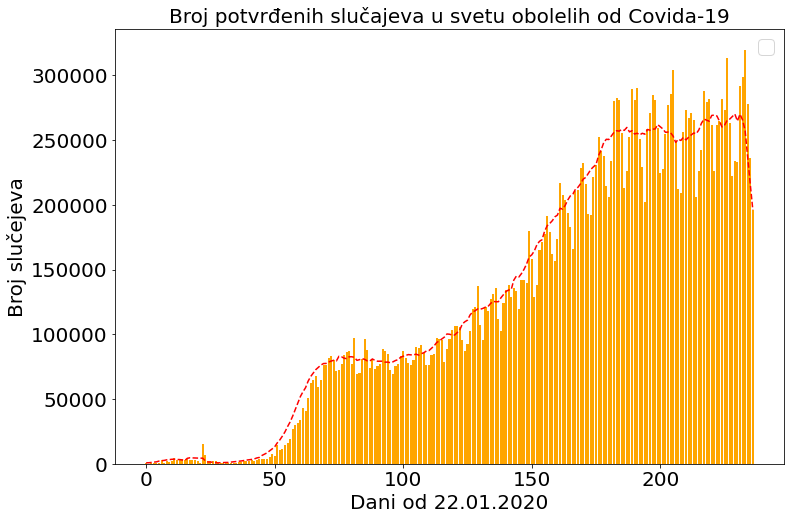

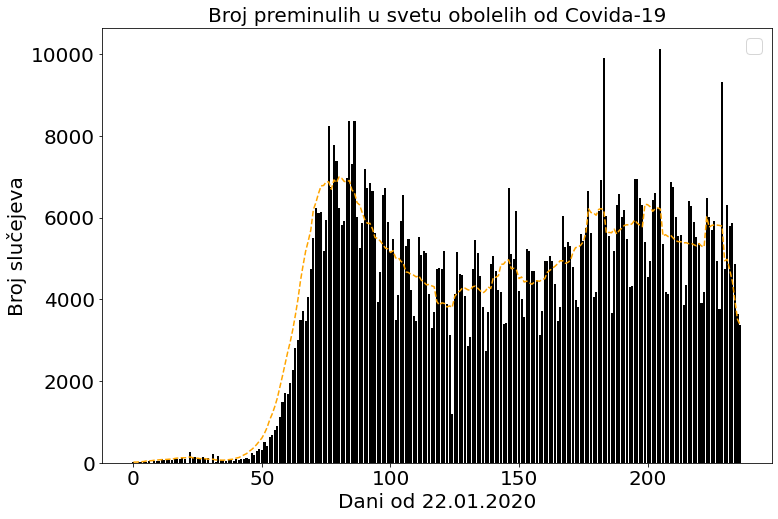

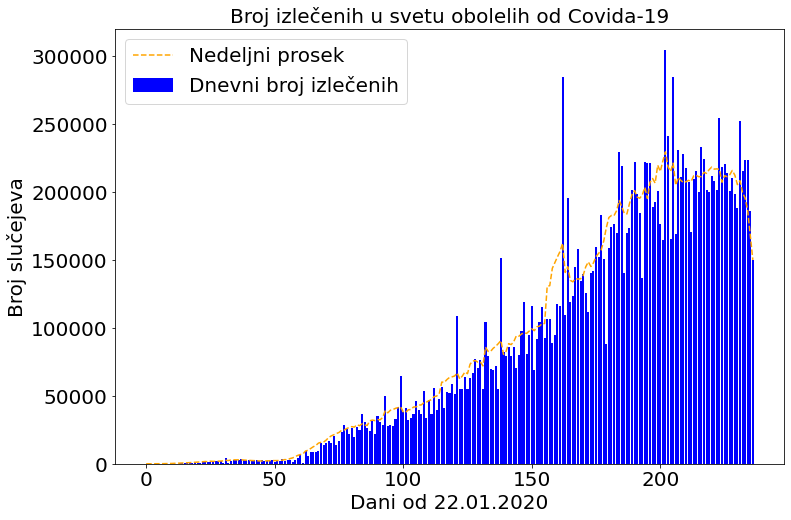

In [23]:
adjusted_dates = future_forcast[:-10] #uzimamo 
adjusted_dates = adjusted_dates.reshape(1, -1)[0]

plt.figure(figsize=(12, 8))
plt.title('Broj potvrđenih slučajeva u svetu obolelih od Covida-19', size=20)
plt.legend(['Nedeljni prosek', 'Dnevni broj slučajeva'], prop={'size': 20})
plt.bar(adjusted_dates, world_daily_increase,color='orange')
plt.plot(adjusted_dates, world_daily_increase_avg, color='red', linestyle='dashed')
plt.xlabel('Dani od 22.01.2020', size=20)
plt.ylabel('Broj slučejeva', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Broj preminulih u svetu obolelih od Covida-19', size=20)
plt.legend(['Nedeljni prosek', 'Dnevni broj preminulih'], prop={'size': 20})
plt.bar(adjusted_dates, world_daily_death,color='black')
plt.plot(adjusted_dates, world_daily_death_avg, color='orange', linestyle='dashed')
plt.xlabel('Dani od 22.01.2020', size=20)
plt.ylabel('Broj slučejeva', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Broj izlečenih u svetu obolelih od Covida-19', size=20)
plt.bar(adjusted_dates, world_daily_recovery,color='blue')
plt.plot(adjusted_dates, world_daily_recovery_avg, color='orange', linestyle='dashed')
plt.xlabel('Dani od 22.01.2020', size=20)
plt.ylabel('Broj slučejeva', size=20)
plt.legend(['Nedeljni prosek', 'Dnevni broj izlečenih'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [24]:
# Lienaarna regresija, predvidjanje broj zarazenih u narednih 10 dana

X_train_cases, X_test_cases, y_train_cases, y_test_cases = train_test_split(days[50:], world_cases[50:], test_size=0.3, shuffle=False) 

poly = PolynomialFeatures(degree=5)
poly_X_train_cases = poly.fit_transform(X_train_cases)
poly_X_test_cases = poly.fit_transform(X_test_cases)
poly_future_forcast = poly.fit_transform(future_forcast)

linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_cases, y_train_cases)
test_linear_pred = linear_model.predict(poly_X_test_cases)
linear_pred = linear_model.predict(poly_future_forcast)


print('MAE:', mean_absolute_error(test_linear_pred, y_test_cases))
print('MSE:',mean_squared_error(test_linear_pred, y_test_cases))

MAE: 1397476.4275422755
MSE: 4437440296224.699


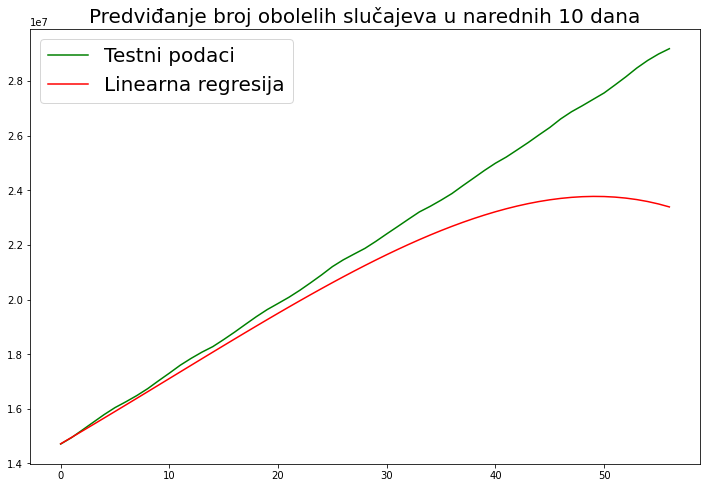

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_cases,color='green')
plt.plot(test_linear_pred,color='red')
plt.title('Predviđanje broj obolelih slučajeva u narednih 10 dana', size=20)
plt.legend(['Testni podaci', 'Linearna regresija'], prop={'size': 20})
plt.show()

In [41]:
X_train_cases, X_test_cases, y_train_cases, y_test_cases = train_test_split(days[50:], world_cases[50:], test_size=0.12, shuffle=False) 

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_cases = bayesian_poly.fit_transform(X_train_cases)
bayesian_poly_X_test_cases = bayesian_poly.fit_transform(X_test_cases)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_cases, y_train_cases)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished


RandomizedSearchCV(cv=3, estimator=BayesianRidge(fit_intercept=False),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'normalize': [True, False],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [42]:
bayesian_search.best_params_
bayesian_cases = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_cases.predict(bayesian_poly_X_test_cases)
bayesian_pred = bayesian_cases.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_cases))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_cases))

MAE: 1600352.1328832675
MSE: 3089864867241.0923


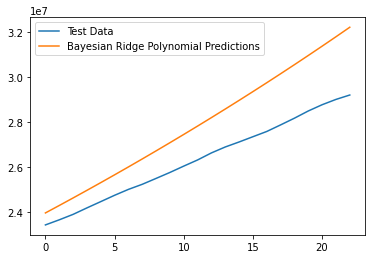

In [43]:
plt.plot(y_test_cases)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])
plt.show()